In [1]:
!pip install 'aif360'

     |████████████████████████████████| 175 kB 5.3 MB/s 
     |████████████████████████████████| 564 kB 23.8 MB/s 
  Created wheel for memory-profiler: filename=memory_profiler-0.60.0-py3-none-any.whl size=31284 sha256=a25f3f848c4708a811438150a21cecb768d058fbcdcc251a118c2fd6b72065df
  Stored in directory: /root/.cache/pip/wheels/67/2b/fb/326e30d638c538e69a5eb0aa47f4223d979f502bbdb403950f
Successfully built memory-profiler


In [2]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult


In [3]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

--2022-05-11 11:03:02--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  9.14MB/s    in 0.4s    

2022-05-11 11:03:04 (9.14 MB/s) - ‘adult.data’ saved [3974305/3974305]

--2022-05-11 11:03:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5229 (5.1K) [application/x-httpd-php]
Saving to: ‘adult.names’

adult.names         100%[===================>]   5.11K  --.-KB/s    in 0s      

2022-

In [4]:
pip install fairlearn

     |████████████████████████████████| 177 kB 5.6 MB/s 


In [5]:
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
import numpy as np
from sklearn.preprocessing import StandardScaler
from aif360.metrics import ClassificationMetric
from sklearn.model_selection import StratifiedKFold

np.random.seed(4) #set random seed

In [6]:
OG_dataset = load_preproc_data_adult(['sex','race'])#setting the protected attributes to sex and race 

OG_dataset_train, OG_dataset_test = OG_dataset.split([0.7], shuffle=True) 

privileged_groups = [{'sex': 1, 'race': 1}] #Male, white
unprivileged_groups = [{'sex': 0, 'race': 0}] #Female, non-white 

#Normalise all the data (as per the lab class)
scale = StandardScaler()
X_train = scale.fit_transform(OG_dataset_train.features) #scales each feature/variable to unit variance
y_train = OG_dataset_train.labels.ravel() #Flattens array

X_test = scale.transform(OG_dataset_test.features) 
y_test = OG_dataset_test.labels.ravel() 

In [7]:
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression

In [8]:
#same process as before 

Cross_Validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
Model = LogisticRegression(solver='liblinear', random_state=1)

Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation)
# report performance
print('Accuracy: %.3f  Standard deviation: %.3f' % (mean(Scores), std(Scores)))

Accuracy: 0.804  Standard deviation: 0.004


In [9]:
C_Values=[100000, 1000, 10, 1.0, 0.01, 0.0001, 0.000001, 0.00000001]

my_dict = {}

accuracy = []

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation)
  print("C value = " +  str(i) + '  Accuracy: %.3f' % (mean(Scores)))
  accuracy.append(mean(Scores))

for i in range(len(C_Values)):
    my_dict[C_Values[i]] = accuracy[i]

find_best_accuracy = max(my_dict, key=my_dict.get)

print( "The model with the highest accuracy has a C value of: ", find_best_accuracy)

C value = 100000  Accuracy: 0.804
C value = 1000  Accuracy: 0.804
C value = 10  Accuracy: 0.804
C value = 1.0  Accuracy: 0.804
C value = 0.01  Accuracy: 0.805
C value = 0.0001  Accuracy: 0.798
C value = 1e-06  Accuracy: 0.796
C value = 1e-08  Accuracy: 0.796
The model with the highest accuracy has a C value of:  0.01


In [10]:
C_Values=[100000, 1000, 10, 1.0, 0.01, 0.0001, 0.000001, 0.00000001]

my_dict = {}
fairness = []
value= 0

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation)

  predictions = cross_val_predict(Model, X_train, y_train, cv=Cross_Validation)

  train_predictions = OG_dataset_train.copy()
  train_predictions.labels = predictions

  Metric = ClassificationMetric(OG_dataset_train, train_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
  Equal_of_Opp = Metric.equal_opportunity_difference()
  print("C value = " +  str(i) + '  Equality_of_Opportunity score: %.3f' % Equal_of_Opp)
  fairness.append(Equal_of_Opp)

for i in range(len(C_Values)):
    my_dict[C_Values[i]] = fairness[i]

fair_key, fair_val = min(my_dict.items(), key=lambda x: abs(value - x[1]))

print( "The model with the highest fairness has a C value of: ", fair_key)

C value = 100000  Equality_of_Opportunity score: -0.468
C value = 1000  Equality_of_Opportunity score: -0.468
C value = 10  Equality_of_Opportunity score: -0.468
C value = 1.0  Equality_of_Opportunity score: -0.468
C value = 0.01  Equality_of_Opportunity score: -0.464
C value = 0.0001  Equality_of_Opportunity score: -0.468
C value = 1e-06  Equality_of_Opportunity score: -0.310
C value = 1e-08  Equality_of_Opportunity score: -0.252
The model with the highest fairness has a C value of:  1e-08


In [11]:
Model_1 = find_best_accuracy
Model_2 = fair_key

In [12]:
from sklearn.model_selection import cross_validate

In [13]:
print("C value = ", Model_1)
Model = LogisticRegression(C=Model_1, solver='liblinear')
Model.fit(X_train, y_train)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  0.01
Accuracy 0.8027025182556473
Equality_of_Opportunity score: -0.464


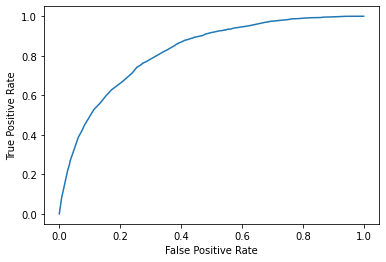

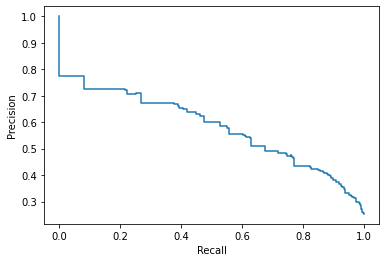

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

#code for graphs adapted from scikit learn[16]

In [15]:
print("C value = ", Model_2)
Model = LogisticRegression(C=Model_2, solver='liblinear')
Model.fit(X_train, y_train)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  1e-08
Accuracy 0.7963556950795059
Equality_of_Opportunity score: -0.223


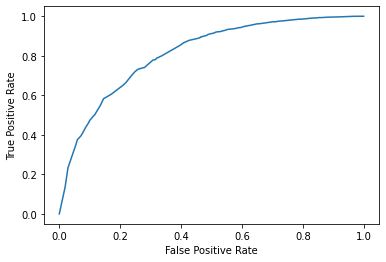

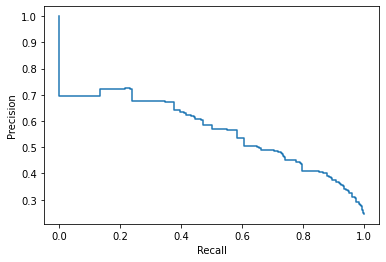

In [16]:

y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [17]:
from aif360.algorithms.preprocessing.reweighing import Reweighing

my_dict1 = {}
my_dict2 = {}
accuracy = []
fairness = []

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
train = RW.fit_transform(OG_dataset_train)
weights = train.instance_weights

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, fit_params= {'sample_weight': weights}, scoring='accuracy', cv=Cross_Validation)
  accuracy.append(mean(Scores))

  predictions = cross_val_predict(Model, X_train, y_train, fit_params= {'sample_weight': weights}, cv=Cross_Validation)
  train_predictions = OG_dataset_train.copy()
  train_predictions.labels = predictions

  Metric = ClassificationMetric(OG_dataset_train, train_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
  Equal_of_Opp = Metric.equal_opportunity_difference()
  fairness.append(Equal_of_Opp)
  print("C value = " +  str(i) + '  Accuracy: %.3f' % (mean(Scores)) + '  Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

for i in range(len(C_Values)):
    my_dict1[C_Values[i]] = accuracy[i]

find_best_accuracy = max(my_dict1, key=my_dict1.get)

print( "The model with the highest accuracy has a C value of: ", find_best_accuracy)

for i in range(len(C_Values)):
    my_dict2[C_Values[i]] = fairness[i]

fair_key, fair_val = min(my_dict2.items(), key=lambda x: abs(value - x[1]))

print( "The model with the best fairness has a C value of: ", fair_key)

C value = 100000  Accuracy: 0.795  Equality_of_Opportunity score: -0.094
C value = 1000  Accuracy: 0.795  Equality_of_Opportunity score: -0.094
C value = 10  Accuracy: 0.795  Equality_of_Opportunity score: -0.094
C value = 1.0  Accuracy: 0.795  Equality_of_Opportunity score: -0.094
C value = 0.01  Accuracy: 0.795  Equality_of_Opportunity score: -0.094
C value = 0.0001  Accuracy: 0.795  Equality_of_Opportunity score: -0.139
C value = 1e-06  Accuracy: 0.795  Equality_of_Opportunity score: -0.096
C value = 1e-08  Accuracy: 0.795  Equality_of_Opportunity score: -0.096
The model with the highest accuracy has a C value of:  0.0001
The model with the best fairness has a C value of:  100000


In [25]:
Model_3 = find_best_accuracy
Model_4 = fair_key

In [26]:
print("C value = ", Model_3)
Model = LogisticRegression(C=Model_3, solver='liblinear')
Model.fit(X_train, y_train, sample_weight = weights)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  0.0001
Accuracy 0.7964921859004982
Equality_of_Opportunity score: -0.158


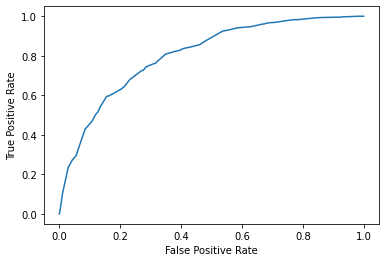

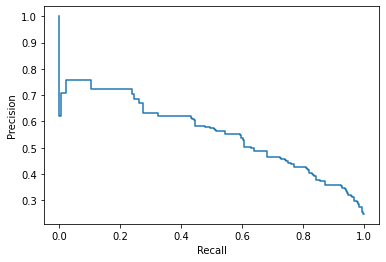

In [27]:

y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [28]:
print("C value = ", Model_4)
Model = LogisticRegression(C=Model_4, solver='liblinear')
Model.fit(X_train, y_train, sample_weight = weights)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  100000
Accuracy 0.7928751791442026
Equality_of_Opportunity score: -0.019


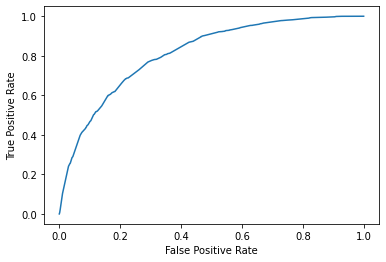

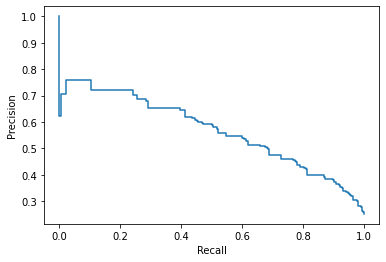

In [29]:

y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [30]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/german

/usr/local/lib/python3.7/dist-packages/aif360/data/raw/german


In [31]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data

--2022-05-11 11:10:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79793 (78K) [application/x-httpd-php]
Saving to: ‘german.data’

german.data         100%[===================>]  77.92K  --.-KB/s    in 0.1s    

2022-05-11 11:10:48 (775 KB/s) - ‘german.data’ saved [79793/79793]



In [32]:
from aif360.datasets import GermanDataset
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_german

np.random.seed(4)

In [33]:
OG_dataset = load_preproc_data_german(['age','sex']) #setting the protected attribute to age

OG_dataset_train, OG_dataset_test = OG_dataset.split([0.7], shuffle=True) #Split the dataset, 70% for training and 30% for test

privileged_groups2 = [{'age': 1, 'sex': 1}] #Over 25
unprivileged_groups2 = [{'age': 0, 'sex': 0}] #Under 25

#Normalise all the data (as per the lab class)
scale = StandardScaler()
X_train = scale.fit_transform(OG_dataset_train.features) #scales each feature/variable to unit variance
y_train = OG_dataset_train.labels.ravel() #Flattens array

X_test = scale.transform(OG_dataset_test.features) 
y_test = OG_dataset_test.labels.ravel()

In [34]:
Cross_Validation = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
Model = LogisticRegression(solver='liblinear', random_state=1)

Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation)
print('Accuracy: %.3f  Standard deviation: %.3f' % (mean(Scores), std(Scores)))

Accuracy: 0.714  Standard deviation: 0.012


In [35]:
C_Values=[100000, 1000, 10, 1.0, 0.01, 0.0001, 0.000001, 0.00000001]

my_dict = {}
accuracy = []

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation)
  print("C value = " +  str(i) + '  Accuracy: %.3f' % (mean(Scores)))
  accuracy.append(mean(Scores))

for i in range(len(C_Values)):
    my_dict[C_Values[i]] = accuracy[i]

find_best_accuracy = max(my_dict, key=my_dict.get)

print( "The model with the highest accuracy has a C value of: ", find_best_accuracy)

C value = 100000  Accuracy: 0.714
C value = 1000  Accuracy: 0.714
C value = 10  Accuracy: 0.714
C value = 1.0  Accuracy: 0.714
C value = 0.01  Accuracy: 0.720
C value = 0.0001  Accuracy: 0.660
C value = 1e-06  Accuracy: 0.660
C value = 1e-08  Accuracy: 0.660
The model with the highest accuracy has a C value of:  0.01


In [36]:
C_Values=[100000, 1000, 10, 1.0, 0.01, 0.0001, 0.000001, 0.00000001]

my_dict = {}
fairness = []

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, scoring='accuracy', cv=Cross_Validation)

  predictions = cross_val_predict(Model, X_train, y_train, cv=Cross_Validation)

  train_predictions = OG_dataset_train.copy()
  train_predictions.labels = predictions

  Metric = ClassificationMetric(OG_dataset_train, train_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
  Equal_of_Opp = Metric.equal_opportunity_difference()
  print("C value = " +  str(i) + '  Equality_of_Opportunity score: %.3f' % Equal_of_Opp)
  fairness.append(Equal_of_Opp)

for i in range(len(C_Values)):
    my_dict[C_Values[i]] = fairness[i]

fair_key, fair_val = min(my_dict.items(), key=lambda x: abs(value - x[1]))

print( "The model with the highest fairness has a C value of: ", fair_key)

C value = 100000  Equality_of_Opportunity score: -0.237
C value = 1000  Equality_of_Opportunity score: -0.237
C value = 10  Equality_of_Opportunity score: -0.237
C value = 1.0  Equality_of_Opportunity score: -0.237
C value = 0.01  Equality_of_Opportunity score: -0.237
C value = 0.0001  Equality_of_Opportunity score: -0.302
C value = 1e-06  Equality_of_Opportunity score: -0.302
C value = 1e-08  Equality_of_Opportunity score: -0.302
The model with the highest fairness has a C value of:  100000


In [37]:
Model_1 = find_best_accuracy
Model_2 = fair_key

In [38]:
print("C value = ", Model_1)
Model = LogisticRegression(C=Model_1, solver='liblinear')
Model.fit(X_train, y_train)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  0.01
Accuracy 0.67
Equality_of_Opportunity score: -0.332


In [40]:
print("C value = ", Model_2)
Model = LogisticRegression(C=Model_2, solver='liblinear')
Model.fit(X_train, y_train)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  100000
Accuracy 0.67
Equality_of_Opportunity score: -0.332


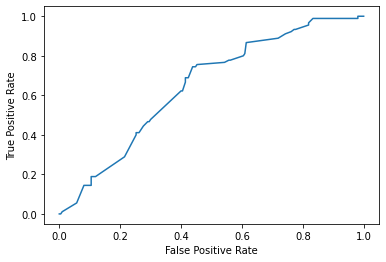

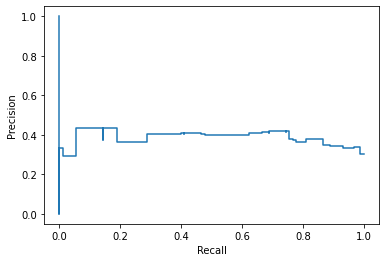

In [41]:

y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

In [42]:
my_dict1 = {}
my_dict2 = {}
accuracy = []
fairness = []

RW = Reweighing(unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
train = RW.fit_transform(OG_dataset_train)
weights = train.instance_weights

for i in C_Values:
  Model = LogisticRegression(C=i, solver='liblinear')
  Scores = cross_val_score(Model, X_train, y_train, fit_params= {'sample_weight': weights}, scoring='accuracy', cv=Cross_Validation)
  accuracy.append(mean(Scores))

  predictions = cross_val_predict(Model, X_train, y_train, fit_params= {'sample_weight': weights}, cv=Cross_Validation)
  train_predictions = OG_dataset_train.copy()
  train_predictions.labels = predictions

  Metric = ClassificationMetric(OG_dataset_train, train_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
  Equal_of_Opp = Metric.equal_opportunity_difference()
  fairness.append(Equal_of_Opp)
  print("C value = " +  str(i) + '  Accuracy: %.3f' % (mean(Scores)) + '  Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

for i in range(len(C_Values)):
    my_dict1[C_Values[i]] = accuracy[i]

find_best_accuracy = max(my_dict1, key=my_dict1.get)

print( "The model with the highest accuracy has a C value of: ", find_best_accuracy)

for i in range(len(C_Values)):
    my_dict2[C_Values[i]] = fairness[i]

fair_key, fair_val = min(my_dict2.items(), key=lambda x: abs(value - x[1]))

print( "The model with the best fairness has a C value of: ", fair_key)

C value = 100000  Accuracy: 0.701  Equality_of_Opportunity score: 0.007
C value = 1000  Accuracy: 0.701  Equality_of_Opportunity score: 0.007
C value = 10  Accuracy: 0.701  Equality_of_Opportunity score: 0.007
C value = 1.0  Accuracy: 0.701  Equality_of_Opportunity score: 0.007
C value = 0.01  Accuracy: 0.673  Equality_of_Opportunity score: 0.106
C value = 0.0001  Accuracy: 0.673  Equality_of_Opportunity score: -0.056
C value = 1e-06  Accuracy: 0.673  Equality_of_Opportunity score: -0.056
C value = 1e-08  Accuracy: 0.673  Equality_of_Opportunity score: -0.056
The model with the highest accuracy has a C value of:  100000
The model with the best fairness has a C value of:  100000


In [43]:
Model_3 = find_best_accuracy
Model_4 = fair_key

In [44]:
print("C value = ", Model_3)
Model = LogisticRegression(C=Model_3, solver='liblinear')
Model.fit(X_train, y_train, sample_weight = weights)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  100000
Accuracy 0.6866666666666666
Equality_of_Opportunity score: -0.038


In [45]:
print("C value = ", Model_4)
Model = LogisticRegression(C=Model_4, solver='liblinear')
Model.fit(X_train, y_train, sample_weight = weights)
predictions = Model.predict(X_test)

test_predictions = OG_dataset_test.copy()
test_predictions.labels = predictions
print("Accuracy", sum(predictions==y_test)/len(y_test))

Metric = ClassificationMetric(OG_dataset_test, test_predictions , unprivileged_groups=unprivileged_groups2, privileged_groups=privileged_groups2)
Equal_of_Opp = Metric.equal_opportunity_difference()
print('Equality_of_Opportunity score: %.3f' % Equal_of_Opp)

C value =  100000
Accuracy 0.6866666666666666
Equality_of_Opportunity score: -0.038


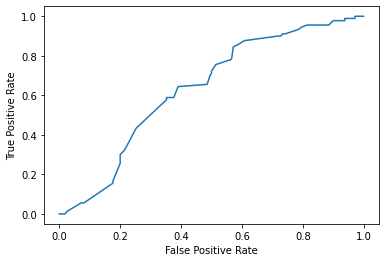

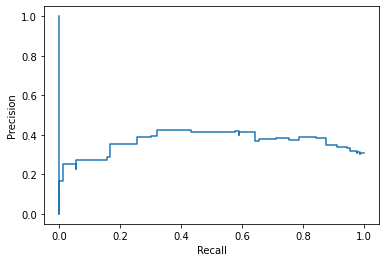

In [46]:
y_score = Model.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=Model.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

prec, recall, _ = precision_recall_curve(y_test, y_score, pos_label=Model.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()